# 고객 대출등급 예측 데이터셋
- multi-class 데이터셋
- 학습 데이터
    - https://drive.google.com/file/d/14IjwnpOHB7NBgEiujPErY3C5X5E6LAzi/view?usp=sharing
- 평가 데이터
    - https://drive.google.com/file/d/13B0Kstc31VQxxsu5nm6RhKlGTehdhrPD/view?usp=sharing

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
DATA_PATH = "/content/drive/MyDrive/the_datas/data/"
SEED = 42

In [3]:
import pandas as pd
import numpy as np

train_tr = pd.read_csv(f"{DATA_PATH}train_tr_common_1.csv") # 학습용 구매기록 데이터
train_target = pd.read_csv(f"{DATA_PATH}store_train.csv") # 학습용 정답 데이터
test_tr = pd.read_csv(f"{DATA_PATH}test_tr_common_1.csv") # 테스트용 구매기록 데이터
submit = pd.read_csv(f"{DATA_PATH}store_submission.csv") # 제출 양식 데이터

train_tr.shape , train_target.shape , test_tr.shape , submit.shape

((523105, 12), (14940, 2), (441196, 12), (12225, 2))

In [5]:
import pandas as pd
import numpy as np

train_ft = pd.read_csv(f"{DATA_PATH}train_common_4.csv")
test_ft = pd.read_csv(f"{DATA_PATH}test_common_4.csv")


train_ft.shape, test_ft.shape

((14940, 450), (12225, 450))

In [6]:
agg_list = [
            ('중분류_아동_cnt', lambda x: x.str.contains('아동').sum()),
            ]
tmp = train_tr.groupby('ID')["중분류"].agg(agg_list).reset_index()
train_ft = train_ft.merge(tmp, how='left')
tmp = test_tr.groupby('ID')["중분류"].agg(agg_list).reset_index()
test_ft = test_ft.merge(tmp, how='left')

train_ft['가족단위_구매비율'] = train_ft['대분류_아동_cnt'] + train_ft['중분류_아동_cnt'] / train_ft['구매건수']
test_ft['가족단위_구매비율'] = test_ft['대분류_아동_cnt'] + test_ft['중분류_아동_cnt'] / test_ft['구매건수']
train_ft.shape, test_ft.shape

((14940, 452), (12225, 452))

In [7]:
train_ft.head()

,ID,구매횟수,내점일수,구매주기,봄_구매비율,여름_구매비율,가을_구매비율,겨울_구매비율,주구매요일,12시이전구매비율,...,대_pivot_횟수비율A373000_명품잡화,대_pivot_횟수비율A373000_생식품,대_pivot_횟수비율A373000_아동_스포츠,대_pivot_횟수비율A373000_여성정장,대_pivot_횟수비율A373000_여성캐주얼,대_pivot_횟수비율A373000_패션잡화,하루 구매 시간 간격_y,대분류_영_cnt,중분류_아동_cnt,가족단위_구매비율
0,train_0,16,11,23,0.050000,0.250000,0.400000,0.300000,3,0.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2220.0,0,1,2.050000
1,train_1,41,21,16,0.357143,0.166667,0.357143,0.119048,3,0.214286,...,0.048780,0.000000,0.000000,0.024390,0.048780,0.000000,14580.0,15,0,1.000000
2,train_2,102,56,6,0.464912,0.140351,0.175439,0.219298,0,0.122807,...,1.736842,0.157895,0.947368,0.157895,0.263158,0.368421,16680.0,0,0,18.000000
3,train_3,191,92,3,0.379147,0.180095,0.236967,0.203791,3,0.161137,...,0.200000,0.000000,0.000000,0.050000,0.300000,0.000000,25800.0,9,0,57.000000
4,train_4,55,27,11,0.112903,0.612903,0.209677,0.064516,4,0.096774,...,0.714286,0.000000,0.000000,0.000000,0.000000,0.000000,18000.0,0,3,8.048387


# 브랜드코드

In [8]:
train_brand = train_tr.groupby("브랜드코드").count().reset_index()[["브랜드코드"]]
train_brand

,브랜드코드
0,5100
1,5101
2,5102
3,5103
4,5104
...,...
1825,6990
1826,6992
1827,6994
1828,6995


In [9]:
train_brand_result = train_tr.groupby("브랜드코드").count().reset_index()[["브랜드코드"]]
train_brand_result

,브랜드코드
0,5100
1,5101
2,5102
3,5103
4,5104
...,...
1825,6990
1826,6992
1827,6994
1828,6995


## 특성 생성

In [10]:
train_tr['구매일시'] = pd.to_datetime(train_tr['구매일시'])

In [11]:
agg_list = [
        # 컬럼명, 집계 방식
        ('거래횟수','nunique'),
        ('내점일수', lambda x: x.dt.date.nunique()),
        ('구매주기', lambda x: int( (x.max() - x.min()).days / x.dt.date.nunique()) ),

        ('봄_구매비율', lambda x: np.mean(x.dt.month.isin([3,4,5]))),
        ('여름_구매비율', lambda x: np.mean(x.dt.month.isin([6,7,8]))),
        ('가을_구매비율', lambda x: np.mean(x.dt.month.isin([9,10,11]))),
        ('겨울_구매비율', lambda x: np.mean(x.dt.month.isin([1,2,12]))),
        ('주구매요일', lambda x: x.dt.weekday.mode()[0]),

        #추가 내용
        ('12시이전구매비율', lambda x: np.mean(x.dt.hour <= 12)),
        ('12시이후_18시이전구매비율', lambda x: np.mean((x.dt.hour > 12) & (x.dt.hour < 18))),
        ('18시이후구매비율', lambda x: np.mean(x.dt.hour >= 18)),
        ('주중방문비율', lambda x : np.mean(x.dt.weekday < 5)),
        ('주말방문비율', lambda x : np.mean(x.dt.weekday >= 5)),
        ('평일_18시_구매비율', lambda x: ((x.dt.weekday < 5) & (x.dt.hour >= 18)).mean()),
        ('방문평균거래평균횟수', lambda x: x.nunique()/x.dt.date.nunique()),

        ('금토일방문비율', lambda x : np.mean(x.dt.weekday >= 4)),
        ('금오후토일방문비율', lambda x: np.mean((x.dt.weekday >= 5) | ((x.dt.weekday == 4) & (x.dt.hour >= 18)))),
        #('월화수방문비율', lambda x : np.mean(x.dt.weekday < 3)),

        ('주구매시간', lambda x: x.dt.hour.mode()[0] if len(x.dt.hour.mode()) > 0 else -1),



    ]

tmp = train_tr.groupby('브랜드코드')["구매일시"].agg(agg_list).reset_index()
train_brand = train_brand.merge(tmp, how='left',on="브랜드코드")
train_brand.head()

,브랜드코드,거래횟수,내점일수,구매주기,봄_구매비율,여름_구매비율,가을_구매비율,겨울_구매비율,주구매요일,12시이전구매비율,12시이후_18시이전구매비율,18시이후구매비율,주중방문비율,주말방문비율,평일_18시_구매비율,방문평균거래평균횟수,금토일방문비율,금오후토일방문비율,주구매시간
0,5100,19018,337,1,0.256424,0.253779,0.238345,0.251453,4,0.182722,0.594636,0.222642,0.774654,0.225346,0.174342,56.433234,0.413140,0.271194,17
1,5101,730,292,1,0.301442,0.234600,0.200524,0.263434,4,0.167759,0.592398,0.239843,0.788991,0.211009,0.184797,2.500000,0.402359,0.263434,15
2,5102,277,169,2,0.308772,0.189474,0.249123,0.252632,3,0.214035,0.603509,0.182456,0.807018,0.192982,0.164912,1.639053,0.392982,0.252632,15
3,5103,295,177,2,0.173633,0.279743,0.247588,0.299035,3,0.147910,0.565916,0.286174,0.771704,0.228296,0.205788,1.666667,0.427653,0.282958,19
4,5104,1661,310,1,0.285080,0.081531,0.356628,0.276761,4,0.165835,0.589573,0.244592,0.814199,0.185801,0.203550,5.358065,0.388242,0.242374,18


In [12]:
agg_list = [
        ('총구매액','sum'),
        ('구매건수', 'count'),
        ('평균구매액', "mean"),
        ('최대구매액', 'max'),
        ('최소구매액',lambda x: x[x > 0].min() ) ,
        ('환불금액',lambda x: x[x < 0].sum() ) ,
        ('환불건수', lambda x: ( x < 0 ).sum() ),
        ('구매금액표준편차',lambda x: x[x>0].std() ),

        #추가내용
        ('구매금액왜도', lambda x: x[x > 0].skew()),
        ('구매금액첨도', lambda x: x[x > 0].kurtosis()),
        ('구매금액_1q', lambda x: x[x > 0].quantile(0.25)),
        ('구매금액_2q', lambda x: x[x > 0].quantile(0.5)),
        ('구매금액_3q', lambda x: x[x > 0].quantile(0.75))


    ]

tmp = train_tr.groupby('브랜드코드')["구매가격"].agg(agg_list).reset_index()
train_brand = train_brand.merge(tmp, how='left',on="브랜드코드")
train_brand.head()

,브랜드코드,거래횟수,내점일수,구매주기,봄_구매비율,여름_구매비율,가을_구매비율,겨울_구매비율,주구매요일,12시이전구매비율,...,최대구매액,최소구매액,환불금액,환불건수,구매금액표준편차,구매금액왜도,구매금액첨도,구매금액_1q,구매금액_2q,구매금액_3q
0,5100,19018,337,1,0.256424,0.253779,0.238345,0.251453,4,0.182722,...,17740000,270.0,-77525337,831,107751.639924,74.592249,9251.884461,14500.0,27650.0,51081.0
1,5101,730,292,1,0.301442,0.234600,0.200524,0.263434,4,0.167759,...,246000,3000.0,-683500,17,24049.116168,3.030115,15.590728,14000.0,21300.0,35000.0
2,5102,277,169,2,0.308772,0.189474,0.249123,0.252632,3,0.214035,...,238400,4000.0,-62400,2,33878.970645,2.811862,10.311851,18400.0,29000.0,44500.0
3,5103,295,177,2,0.173633,0.279743,0.247588,0.299035,3,0.147910,...,260000,1600.0,-1656800,23,47920.222667,2.252675,5.430467,24750.0,39200.0,62000.0
4,5104,1661,310,1,0.285080,0.081531,0.356628,0.276761,4,0.165835,...,560000,64.0,-1574124,49,31744.726413,9.231231,125.720746,11050.0,15050.0,27000.0


In [13]:
# agg_list = [
#              ('최다구매ID', lambda x: x.value_counts().index[0]),
#              ('최다구매ID_구매횟수', lambda x: x.value_counts().iloc[0]),
#              ]

# tmp = train_tr.groupby('브랜드코드')["ID"].agg(agg_list).reset_index()
# train_brand = train_brand.merge(tmp, how='left',on="브랜드코드")
# train_brand.head()

In [14]:
agg_list = [
            ('중분류_nunique', 'nunique'),
            ('주구매_중분류', lambda x: x.mode()[0]),
            ]
tmp = train_tr.groupby('브랜드코드')["중분류"].agg(agg_list).reset_index()
train_brand = train_brand.merge(tmp, how='left',on="브랜드코드")
train_brand.head()

,브랜드코드,거래횟수,내점일수,구매주기,봄_구매비율,여름_구매비율,가을_구매비율,겨울_구매비율,주구매요일,12시이전구매비율,...,환불금액,환불건수,구매금액표준편차,구매금액왜도,구매금액첨도,구매금액_1q,구매금액_2q,구매금액_3q,중분류_nunique,주구매_중분류
0,5100,19018,337,1,0.256424,0.253779,0.238345,0.251453,4,0.182722,...,-77525337,831,107751.639924,74.592249,9251.884461,14500.0,27650.0,51081.0,29,용기보증
1,5101,730,292,1,0.301442,0.234600,0.200524,0.263434,4,0.167759,...,-683500,17,24049.116168,3.030115,15.590728,14000.0,21300.0,35000.0,3,화장잡화
2,5102,277,169,2,0.308772,0.189474,0.249123,0.252632,3,0.214035,...,-62400,2,33878.970645,2.811862,10.311851,18400.0,29000.0,44500.0,4,욕실용품
3,5103,295,177,2,0.173633,0.279743,0.247588,0.299035,3,0.147910,...,-1656800,23,47920.222667,2.252675,5.430467,24750.0,39200.0,62000.0,3,피혁토탈(B2)
4,5104,1661,310,1,0.285080,0.081531,0.356628,0.276761,4,0.165835,...,-1574124,49,31744.726413,9.231231,125.720746,11050.0,15050.0,27000.0,6,스타킹


In [15]:
agg_list = [
            ('대분류_nunique', 'nunique'),
            ('주구매_대분류', lambda x: x.mode()[0]),
            ]
tmp = train_tr.groupby('브랜드코드')["대분류"].agg(agg_list).reset_index()
train_brand = train_brand.merge(tmp, how='left',on="브랜드코드")
train_brand.head()

,브랜드코드,거래횟수,내점일수,구매주기,봄_구매비율,여름_구매비율,가을_구매비율,겨울_구매비율,주구매요일,12시이전구매비율,...,구매금액표준편차,구매금액왜도,구매금액첨도,구매금액_1q,구매금액_2q,구매금액_3q,중분류_nunique,주구매_중분류,대분류_nunique,주구매_대분류
0,5100,19018,337,1,0.256424,0.253779,0.238345,0.251453,4,0.182722,...,107751.639924,74.592249,9251.884461,14500.0,27650.0,51081.0,29,용기보증,4,공산품
1,5101,730,292,1,0.301442,0.234600,0.200524,0.263434,4,0.167759,...,24049.116168,3.030115,15.590728,14000.0,21300.0,35000.0,3,화장잡화,3,잡화파트
2,5102,277,169,2,0.308772,0.189474,0.249123,0.252632,3,0.214035,...,33878.970645,2.811862,10.311851,18400.0,29000.0,44500.0,4,욕실용품,2,가정용품
3,5103,295,177,2,0.173633,0.279743,0.247588,0.299035,3,0.147910,...,47920.222667,2.252675,5.430467,24750.0,39200.0,62000.0,3,피혁토탈(B2),2,영플라자
4,5104,1661,310,1,0.285080,0.081531,0.356628,0.276761,4,0.165835,...,31744.726413,9.231231,125.720746,11050.0,15050.0,27000.0,6,스타킹,4,잡화파트


In [16]:
train_brand.shape

(1830, 36)

# 저장

In [17]:
train_brand.to_csv(f"{DATA_PATH}train_brand_처리전_김이지.csv",index=False)

# 결측치 처리

In [18]:
mask = train_brand.isnull().sum() > 0
train_brand.isnull().sum()[mask]

,0
최소구매액,1
구매금액표준편차,94
구매금액왜도,155
구매금액첨도,209
구매금액_1q,1
구매금액_2q,1
구매금액_3q,1


In [19]:

train_brand["구매금액표준편차"] = train_brand["구매금액표준편차"].fillna(0)
train_brand["구매금액왜도"] = train_brand["구매금액왜도"].fillna(0)
train_brand["구매금액첨도"] = train_brand["구매금액첨도"].fillna(0)
train_brand["구매금액_1q"] = train_brand["구매금액_1q"].fillna(0)
train_brand["구매금액_2q"] = train_brand["구매금액_2q"].fillna(0)
train_brand["구매금액_3q"] = train_brand["구매금액_3q"].fillna(0)
train_brand["최소구매액"] = train_brand["최소구매액"].fillna(0)





In [20]:
train_brand.isnull().sum().sum()

0

# 특성 선택

In [21]:
# train_ft = train_ft.iloc[:,1:-1].copy()
# test_ft = test_ft.iloc[:,1:].copy()
# train_ft.shape, test_ft.shape

# 피처인코딩

In [22]:
cols = train_brand.select_dtypes("object").columns.tolist()
train_brand[cols].nunique()

,0
주구매_중분류,250
주구매_대분류,25


In [23]:
%pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 3.0 MB/s eta 0:00:00


In [24]:
import category_encoders as ce

In [25]:
enc = ce.one_hot.OneHotEncoder()
tmp = enc.fit_transform(train_brand[["주구매_대분류"]])
train_brand = pd.concat([train_brand,tmp],axis =1)


train_brand.shape

(1830, 61)

In [26]:
enc = ce.count.CountEncoder()
train_brand["주구매_중분류"] = enc.fit_transform(train_brand[["주구매_중분류"]])

train_brand.shape


(1830, 61)

In [27]:
cols

['주구매_중분류', '주구매_대분류']

In [28]:

train_brand = train_brand.drop(columns=cols)
train_brand.shape


(1830, 59)

In [29]:
train_brand.select_dtypes("object").columns

Index([], dtype='object')

# 피처 스케일링

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [31]:

train_brand[train_brand.columns] = scaler.fit_transform(train_brand)
train_brand.head()

,브랜드코드,거래횟수,내점일수,구매주기,봄_구매비율,여름_구매비율,가을_구매비율,겨울_구매비율,주구매요일,12시이전구매비율,...,주구매_대분류_16,주구매_대분류_17,주구매_대분류_18,주구매_대분류_19,주구매_대분류_20,주구매_대분류_21,주구매_대분류_22,주구매_대분류_23,주구매_대분류_24,주구매_대분류_25
0,-1.704956,29.513716,2.863063,-0.545609,-0.060199,-0.143344,0.026247,0.211321,0.696640,-0.005488,...,-0.155121,-0.254111,-0.236585,-0.160576,-0.197945,-0.126894,-0.115278,-0.180918,-0.133407,-0.084585
1,-1.703121,0.813444,2.361760,-0.545609,0.123118,-0.216438,-0.142208,0.265768,0.696640,-0.110533,...,-0.155121,-0.254111,-0.236585,-0.160576,-0.197945,-0.126894,-0.115278,-0.180918,-0.133407,-0.084585
2,-1.701287,0.102528,0.991533,-0.446041,0.152968,-0.388427,0.074253,0.216678,0.043874,0.214338,...,-0.155121,-0.254111,-0.236585,-0.160576,-0.197945,-0.126894,-0.115278,-0.180918,-0.133407,-0.084585
3,-1.699452,0.130777,1.080653,-0.446041,-0.397329,-0.044388,0.067419,0.427557,0.043874,-0.249878,...,-0.155121,-0.254111,-0.236585,-0.160576,-0.197945,-0.126894,-0.115278,-0.180918,-0.133407,-0.084585
4,-1.697617,2.274509,2.562281,-0.545609,0.056494,-0.799826,0.553087,0.326333,0.696640,-0.124041,...,-0.155121,-0.254111,-0.236585,-0.160576,-0.197945,-0.126894,-0.115278,-0.180918,-0.133407,-0.084585


In [33]:
train_brand.to_csv(f"{DATA_PATH}train_brand_처리후_김이지.csv",index=False)

# 정답데이터 분리

In [34]:
target = train_target["target"]
target

,target
0,1.0
1,1.0
2,0.0
3,0.0
4,0.0
...,...
14935,0.0
14936,0.0
14937,0.0
14938,1.0


# 군집분석(Clustering analysis)
- 각 데이터의 유사성을 측정하여 다수의 군집으로 나누고 군집 간의 서로 다른 특성을 확인하는 분석​
- 유사도가 높은 데이터끼리 그룹화
- 예측을 위한 모델링 보다는 EDA를 위해 많이 사용(정답 보장 X)


## K-means(K-평균 군집화)
- 거리 기반 군집화로 가장 일반적으로 사용되는 알고리즘
- K개의 랜덤한 중심점으로 시작하여 K개의 중심점을 이동하며 가까운 데이터들을 묶는 군집화 기법​
1. 랜덤하게 K개의 중심점을 지정
2. 각 중심점별로 가까운 데이터들을 그룹화
3. 각 그룹의 평균 지점으로 중심점 이동
4. 중심점 이동 시 그룹에 속한 데이터의 변경이 없을 때까지 2~3단계 반복




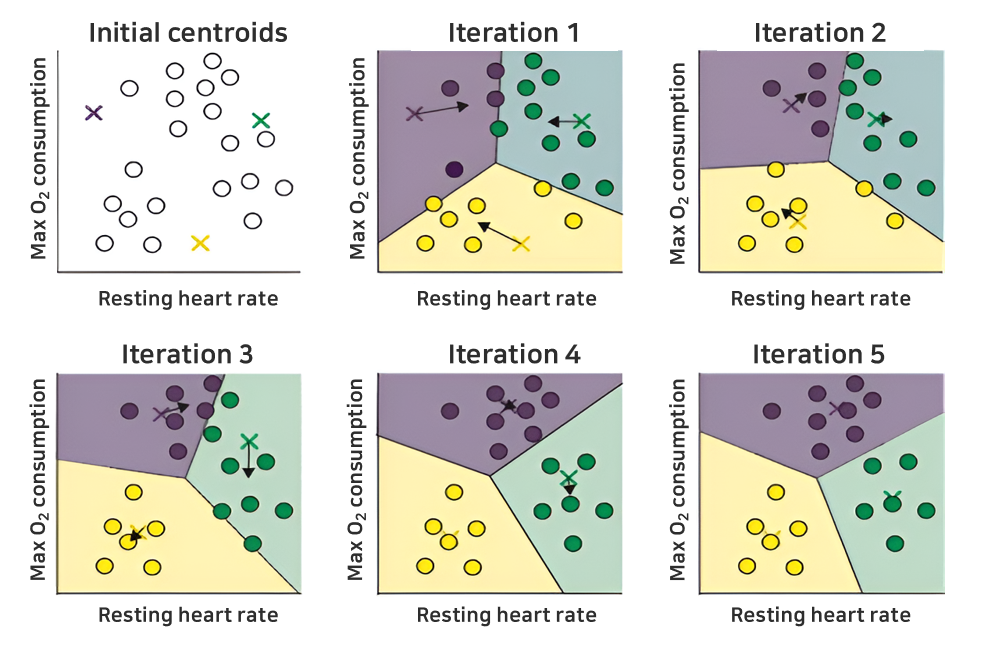

- 초기 중심에 민감하다.
    - 초기중심을 정해야하는 부분이 숙제!!
    - 랜덤하게 지정된 초기중심에 따라 결과가 많이 달라진다
- K-means++
    - 초기 중심점 선정의 어려움을 해결하기 위한 방법
        - 랜덤하게 1개의 데이터샘플을 중심점으로 선택
        - 해당 샘플과 가장 먼 샘플을 2번째 중심점으로 선택
        - 이 과정을 k 개가 될때까지 반복 후 군집화 진행한다.

- KMeans 클래스 주요 파라미터
    - random_state
        - 시드값
    - n_clusters
        - 군집수(K를 의미)
    - init
        - 초기 중심점 선정방법
        - 'k-means++'(기본값) , 'random'

In [35]:
target.nunique()

2

In [39]:
from sklearn.cluster import KMeans
cluster = KMeans(300, random_state=SEED)
cluster.fit(train_brand) # 학습

KMeans(n_clusters=300, random_state=42)

In [40]:
cluster_list = []
from sklearn.metrics import silhouette_score

for i in range(20, 50):
    cluster = KMeans(i, random_state=SEED)
    cluster.fit(train_brand) # 학습
    score = silhouette_score(train_brand, cluster.labels_)
    cluster_list.append((i, score))

cluster_list


[(20, 0.16387446885284968),
 (21, 0.18013470958704977),
 (22, 0.18560697029229495),
 (23, 0.19997275972803852),
 (24, 0.21574206323396364),
 (25, 0.23068866968300147),
 (26, 0.22731563290397575),
 (27, 0.2428174701818728),
 (28, 0.25421529255649755),
 (29, 0.2511346986143706),
 (30, 0.2688083849231082),
 (31, 0.2521771862635258),
 (32, 0.26758221452319836),
 (33, 0.27697797587767187),
 (34, 0.27899142034572105),
 (35, 0.2732964610107792),
 (36, 0.2688544400819291),
 (37, 0.27108055400576725),
 (38, 0.26588713657451585),
 (39, 0.257418297670904),
 (40, 0.259412742860301),
 (41, 0.2568552252194198),
 (42, 0.25471559684554307),
 (43, 0.22823923047466516),
 (44, 0.22994529266686617),
 (45, 0.229025008471724),
 (46, 0.2299497899922562),
 (47, 0.22270444232301456),
 (48, 0.22132740075781965),
 (49, 0.20774358258356806)]

In [41]:
from sklearn.cluster import KMeans
cluster = KMeans(34, random_state=SEED)
cluster.fit(train_brand) # 학습

KMeans(n_clusters=34, random_state=42)

- 학습데이터의 각 샘플에 대한 군집번호

In [42]:
cluster.labels_

array([ 2,  5, 10, ..., 26, 11, 32], dtype=int32)

In [43]:
len(cluster.labels_)

1830

# 추가

In [44]:
train_brand_result["cluster_label"] = cluster.labels_
train_brand_result = train_brand_result[["브랜드코드", "cluster_label"]]

In [45]:
train_brand_result

,브랜드코드,cluster_label
0,5100,2
1,5101,5
2,5102,10
3,5103,18
4,5104,5
...,...,...
1825,6990,21
1826,6992,19
1827,6994,26
1828,6995,11


In [46]:
train_tr = train_tr.merge(train_brand_result, on = "브랜드코드", how = "left")
train_tr

,ID,구매일시,지점코드,대분류,중분류,브랜드코드,구매가격,구매일,구매월,구매요일,구매시간,수정_중분류,cluster_label
0,train_13219,2004-05-01 09:40:00,A144000,공산품파트,차류,5100,59700,2004-05-01,5,5,9,차류,2
1,train_5590,2004-05-01 09:40:00,A144000,잡화파트,화장잡화,5101,17000,2004-05-01,5,5,9,화장잡화,5
2,train_7200,2004-05-01 10:20:00,A112000,공산품,용기보증,5100,34937,2004-05-01,5,5,10,용기보증,2
3,train_3010,2004-05-01 10:30:00,A373000,아동_스포츠,아동복,5105,19000,2004-05-01,5,5,10,아동복,8
4,train_10851,2004-05-01 10:30:00,A112000,가정용품,전화기_카세트,5110,215000,2004-05-01,5,5,10,전화기_카세트,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
523100,train_330,2005-04-29 19:53:00,A112000,영캐릭터,트렌드캐주얼,5882,484000,2005-04-29,4,4,19,트렌드캐주얼,17
523101,train_9738,2005-04-29 19:54:00,A373000,아동_스포츠,상품군미지정,5191,144000,2005-04-29,4,4,19,상품군미지정,20
523102,train_10787,2005-04-29 20:00:00,A112000,공산품,음료,5100,8340,2005-04-29,4,4,20,음료,2
523103,train_13129,2005-04-29 20:00:00,A112000,생식품,용기보증,5100,23170,2005-04-29,4,4,20,용기보증,2


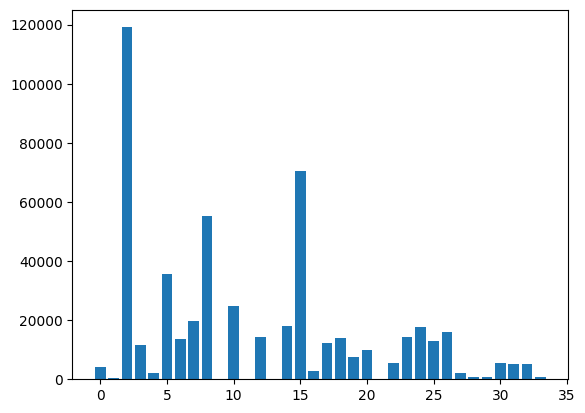

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.bar(train_tr["cluster_label"].value_counts().index, height = train_tr["cluster_label"].value_counts())
plt.show()

In [48]:
test_tr = test_tr.merge(train_brand_result, on = "브랜드코드", how = "left")
test_tr

,ID,구매일시,지점코드,대분류,중분류,브랜드코드,구매가격,구매일,구매월,구매요일,구매시간,수정_중분류,cluster_label
0,test_3366,2004-05-01 10:20:00,A373000,생식품,건식품,5100,7000,2004-05-01,5,5,10,건식품,2.0
1,test_9389,2004-05-01 10:23:00,A373000,명품잡화,스타킹,5104,46000,2004-05-01,5,5,10,스타킹,5.0
2,test_8190,2004-05-01 10:30:00,A144000,잡화파트,수입종합화장품,5106,260000,2004-05-01,5,5,10,수입종합화장품,5.0
3,test_8835,2004-05-01 10:30:00,A144000,잡화파트,준보석,5107,17000,2004-05-01,5,5,10,준보석,5.0
4,test_1167,2004-05-01 10:30:00,A373000,남성의류,셔츠,5108,138000,2004-05-01,5,5,10,셔츠,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
441191,test_10274,2005-04-29 19:53:00,A112000,패션잡화,수입종합화장품,5149,73000,2005-04-29,4,4,19,수입종합화장품,15.0
441192,test_8294,2005-04-29 19:53:00,A112000,여성캐주얼,칼라드래디셔널,6939,188000,2005-04-29,4,4,19,칼라드래디셔널,24.0
441193,test_10919,2005-04-29 19:53:00,A112000,영플라자,스포츠캐주얼,5429,39000,2005-04-29,4,4,19,스포츠캐주얼,8.0
441194,test_808,2005-04-29 19:53:00,A112000,남성의류,셔츠,5651,160000,2005-04-29,4,4,19,셔츠,25.0


In [49]:
test_tr

,ID,구매일시,지점코드,대분류,중분류,브랜드코드,구매가격,구매일,구매월,구매요일,구매시간,수정_중분류,cluster_label
0,test_3366,2004-05-01 10:20:00,A373000,생식품,건식품,5100,7000,2004-05-01,5,5,10,건식품,2.0
1,test_9389,2004-05-01 10:23:00,A373000,명품잡화,스타킹,5104,46000,2004-05-01,5,5,10,스타킹,5.0
2,test_8190,2004-05-01 10:30:00,A144000,잡화파트,수입종합화장품,5106,260000,2004-05-01,5,5,10,수입종합화장품,5.0
3,test_8835,2004-05-01 10:30:00,A144000,잡화파트,준보석,5107,17000,2004-05-01,5,5,10,준보석,5.0
4,test_1167,2004-05-01 10:30:00,A373000,남성의류,셔츠,5108,138000,2004-05-01,5,5,10,셔츠,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
441191,test_10274,2005-04-29 19:53:00,A112000,패션잡화,수입종합화장품,5149,73000,2005-04-29,4,4,19,수입종합화장품,15.0
441192,test_8294,2005-04-29 19:53:00,A112000,여성캐주얼,칼라드래디셔널,6939,188000,2005-04-29,4,4,19,칼라드래디셔널,24.0
441193,test_10919,2005-04-29 19:53:00,A112000,영플라자,스포츠캐주얼,5429,39000,2005-04-29,4,4,19,스포츠캐주얼,8.0
441194,test_808,2005-04-29 19:53:00,A112000,남성의류,셔츠,5651,160000,2005-04-29,4,4,19,셔츠,25.0


In [50]:
no_brand = test_tr[test_tr["cluster_label"].isnull() == True]
no_brand["브랜드코드"].unique()

array([5846, 5830, 5924, 5970, 6159, 6268, 6009, 6302, 6332, 6181, 6410,
       6436, 6474, 6477, 6521, 6545, 6553, 6573, 6618, 6658, 6659, 6703,
       6720, 6692, 6780, 6781, 6819, 6832, 6851, 6854, 6859, 6877, 6895,
       6889, 6202, 6915, 6950, 6998])

In [51]:
test_tr["cluster_label"].isnull().sum()

73

In [52]:
test_tr["cluster_label"] = test_tr["cluster_label"].fillna(151)
test_tr.isnull().sum()

,0
ID,0
구매일시,0
지점코드,0
대분류,0
중분류,0
브랜드코드,0
구매가격,0
구매일,0
구매월,0
구매요일,0


# 브랜드코드 특성 추가

In [53]:
agg_list = [
             ('브랜드코드_cluster_nunique', 'nunique'),
             ('주구매_브랜드_cluster', lambda x: x.mode()[0]),
             ]

tmp = train_tr.groupby('ID')["cluster_label"].agg(agg_list).reset_index()
train_ft = train_ft.merge(tmp, how='left',on="ID")
train_ft.head()

,ID,구매횟수,내점일수,구매주기,봄_구매비율,여름_구매비율,가을_구매비율,겨울_구매비율,주구매요일,12시이전구매비율,...,대_pivot_횟수비율A373000_아동_스포츠,대_pivot_횟수비율A373000_여성정장,대_pivot_횟수비율A373000_여성캐주얼,대_pivot_횟수비율A373000_패션잡화,하루 구매 시간 간격_y,대분류_영_cnt,중분류_아동_cnt,가족단위_구매비율,브랜드코드_cluster_nunique,주구매_브랜드_cluster
0,train_0,16,11,23,0.050000,0.250000,0.400000,0.300000,3,0.300000,...,0.000000,0.000000,0.000000,0.000000,2220.0,0,1,2.050000,10,14
1,train_1,41,21,16,0.357143,0.166667,0.357143,0.119048,3,0.214286,...,0.000000,0.024390,0.048780,0.000000,14580.0,15,0,1.000000,11,15
2,train_2,102,56,6,0.464912,0.140351,0.175439,0.219298,0,0.122807,...,0.947368,0.157895,0.263158,0.368421,16680.0,0,0,18.000000,19,14
3,train_3,191,92,3,0.379147,0.180095,0.236967,0.203791,3,0.161137,...,0.000000,0.050000,0.300000,0.000000,25800.0,9,0,57.000000,18,15
4,train_4,55,27,11,0.112903,0.612903,0.209677,0.064516,4,0.096774,...,0.000000,0.000000,0.000000,0.000000,18000.0,0,3,8.048387,10,2


In [54]:
tmp = test_tr.groupby('ID')["cluster_label"].agg(agg_list).reset_index()
test_ft = test_ft.merge(tmp, how='left',on="ID")
test_ft.head()

,ID,구매횟수,내점일수,구매주기,봄_구매비율,여름_구매비율,가을_구매비율,겨울_구매비율,주구매요일,12시이전구매비율,...,대_pivot_횟수비율A373000_아동_스포츠,대_pivot_횟수비율A373000_여성정장,대_pivot_횟수비율A373000_여성캐주얼,대_pivot_횟수비율A373000_패션잡화,하루 구매 시간 간격_y,대분류_영_cnt,중분류_아동_cnt,가족단위_구매비율,브랜드코드_cluster_nunique,주구매_브랜드_cluster
0,test_0,7,5,32,0.285714,0.285714,0.428571,0.000000,1,0.142857,...,0.0,0.0,0.000000,0.0,4200.0,0,2,2.285714,4,2.0
1,test_1,4,3,54,0.000000,0.000000,0.750000,0.250000,0,0.250000,...,0.0,0.0,0.000000,0.0,600.0,0,0,0.000000,4,15.0
2,test_2,4,2,8,0.000000,0.600000,0.400000,0.000000,0,0.400000,...,0.0,0.0,0.000000,0.0,600.0,0,0,2.000000,3,15.0
3,test_3,28,16,16,0.062500,0.468750,0.343750,0.125000,3,0.000000,...,0.0,0.0,0.000000,0.0,7800.0,17,0,0.000000,9,18.0
4,test_4,19,9,29,0.380952,0.285714,0.238095,0.095238,6,0.000000,...,0.0,0.0,0.015228,0.0,7200.0,1,0,5.000000,6,15.0


In [55]:
train_ft.shape, test_ft.shape

((14940, 454), (12225, 454))

In [56]:
#추가

#대분류, 구매가격 pivot 추가

train_tmp = pd.pivot_table(train_tr,index="ID",columns="cluster_label",values="구매가격",aggfunc="count",fill_value=0).add_prefix("브랜드_cluster_pivot_횟수비율").reset_index()
for col in train_tmp.columns[1:]:
    train_tmp[col] = train_tmp[col]/train_ft["구매횟수"]
train_ft = train_ft.merge(train_tmp,how="left",on="ID")
train_ft.head()
test_tmp = pd.pivot_table(test_tr,index="ID",columns="cluster_label",values="구매가격",aggfunc="count",fill_value=0).add_prefix("브랜드_cluster_pivot_횟수비율").reset_index()
for col in test_tmp.columns[1:]:
    test_tmp[col] = test_tmp[col]/test_ft["구매횟수"]
test_tmp.head()

for col in train_tmp.columns:
    if col not in test_tmp.columns:
        test_tmp[col] = 0

test_tmp = test_tmp[train_tmp.columns]

test_ft = test_ft.merge(test_tmp,how="left",on="ID")
test_ft.head()

,ID,구매횟수,내점일수,구매주기,봄_구매비율,여름_구매비율,가을_구매비율,겨울_구매비율,주구매요일,12시이전구매비율,...,브랜드_cluster_pivot_횟수비율24,브랜드_cluster_pivot_횟수비율25,브랜드_cluster_pivot_횟수비율26,브랜드_cluster_pivot_횟수비율27,브랜드_cluster_pivot_횟수비율28,브랜드_cluster_pivot_횟수비율29,브랜드_cluster_pivot_횟수비율30,브랜드_cluster_pivot_횟수비율31,브랜드_cluster_pivot_횟수비율32,브랜드_cluster_pivot_횟수비율33
0,test_0,7,5,32,0.285714,0.285714,0.428571,0.000000,1,0.142857,...,0,0,0,0,0,0,0,0,0,0
1,test_1,4,3,54,0.000000,0.000000,0.750000,0.250000,0,0.250000,...,0,0,0,0,0,0,0,0,0,0
2,test_2,4,2,8,0.000000,0.600000,0.400000,0.000000,0,0.400000,...,0,0,0,0,0,0,0,0,0,0
3,test_3,28,16,16,0.062500,0.468750,0.343750,0.125000,3,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,test_4,19,9,29,0.380952,0.285714,0.238095,0.095238,6,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [57]:
train_ft.shape, test_ft.shape

((14940, 488), (12225, 488))

#저장

In [58]:
train_ft.to_csv(f"{DATA_PATH}train_ft_군집분석_34_김이지.csv", index=False)
test_ft.to_csv(f"{DATA_PATH}test_ft_군집분석_34_김이지.csv", index=False)

- 예측도 가능!!

In [ ]:
# cluster.predict(test_ft)

## 대표적인 군집화 성능 평가지표
- 군집화가 얼마나 잘되었는지 정량적으로 확인

### 사전에 정의된 그룹이 있는 경우
- 군집화 결과가 얼마나 사전에 정의된 그룹을 설명하는가를 평가
- 예시로 정답클래스가 있는 경우 얼마나 각 클래스처럼 그룹화가 되어 있는가를 평가

- homogeneity_score 함수
    - 각 군집(예측값)이 동일한 클래스(실제값)로 구성되어 있는 정도(동질성)
        - 정밀도와 비슷하다.
        - 0 ~ 1 값이며, 1에 가까울수록 군집화가 잘되었다는 의미

In [ ]:
from sklearn.metrics import homogeneity_score
homogeneity_score(target, cluster.labels_)

ValueError: Found input variables with inconsistent numbers of samples: [14940, 1830]

- completeness_score 함수
    - 각 클래스(실제값)에 대하여 동일한 군집(예측값)으로 구성되어 있는 정도(완전성)
        - 재현율과 비슷하다.
        - 0 ~ 1 값이며, 1에 가까울수록 군집화가 잘되었다는 의미

In [ ]:
from sklearn.metrics import completeness_score
completeness_score(target, cluster.labels_)

0.03247854600045898

- v_measure_score 함수
    - homogeneity 와 completeness의 조화평균
        - 0 ~ 1 값이며, 1에 가까울수록 군집화가 잘되었다는 의미

In [ ]:
from sklearn.metrics import v_measure_score
v_measure_score(target, cluster.labels_)

0.059854318689739054

### 사전에 정의된 그룹이 없는 경우
- 대표적으로 실루엣 계수(silhouette coefficient)가 있다.
    - 군집 내의 거리는 짧을수록 군집 간의 거리가 길수록 좋은 군집화라는 가정을 평가하기 위한 지표
    - -1 ~ 1 의 값을 가진다.
    - 1에 가까울수록 최상의 군집화 되었다는 것을 의미
    - 0 에 가까울수록 군집간의 거리가 가까워지고 겹친다는 것을 의미
    - 음수일경우 잘못된 방식으로 군집화 되었다는 의미

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(train_brand, cluster.labels_)

0.15491122532500137

In [ ]:
from sklearn.metrics import silhouette_samples
scores = silhouette_samples(train_brand, cluster.labels_)
scores.mean()

0.14049155089660206

In [ ]:
scores.min()

-0.2614832576765993

## MiniBatchKMeans 클래스
- Mini-Batch 개수 만큼 무작위로 분리하여 K-means 군집화를 한다.
- 결과가 완전 똑같지는 않지만 k-means 와 비슷하게 나온다.
- 속도가 미니배치 방식이 빠르다.

In [ ]:
from sklearn.cluster import MiniBatchKMeans
cluster = MiniBatchKMeans(150, random_state=SEED, batch_size=32)
cluster.fit(train_brand)

MiniBatchKMeans(batch_size=32, n_clusters=150, random_state=42)

In [ ]:
silhouette_score(train_brand, cluster.labels_)

0.10324466669088553

In [ ]:
v_measure_score(target, cluster.labels_)

0.006115333798162854

## DBSCAN(Density-based spatial clustering of applications with noise)

- 밀도 기반 군집화의 대표적인 알고리즘으로 데이터 밀도 차이를 기반으로 하고 있어 복잡한 기하학적 분포도를 가진 데이터에 대해서도 군집화를 잘 수행하는 기법
1. 랜덤하게 데이터포인트들을 확인하고 지정한 반경 내에 지정한 최소개수만큼의 데이터가 포함되어 있으면
군집화가 되면서 해당 데이터포인트는 핵심포인트가 됨
2. 핵심포인트가 서로 연결(서로 반경 내에 포함)된다면
같은 군집으로 묶임
3. 연결되지 못하거나 최소 군집크기를 충족 못하면 노이즈로 분류됨
4. 모든 데이터포인트가 군집화, 노이즈가 될 때 까지 반복함



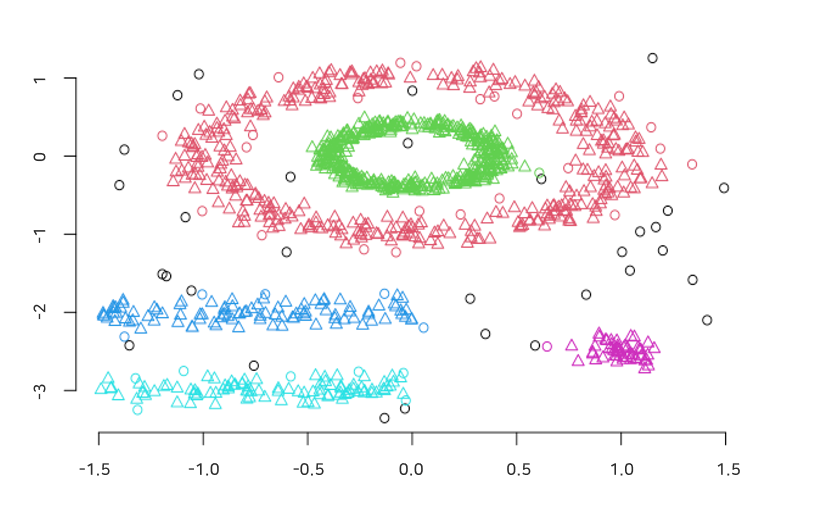

- DBSCAN 클래스 주요 파라미터
    - eps
        - 이웃으로 판단하는 최대 거리(반경)
    - min_samples
        - 이웃 반경 내 최소 샘플 수
    - predict 메서드 없음!!

In [ ]:
train_brand

,브랜드코드,거래횟수,내점일수,구매주기,봄_구매비율,여름_구매비율,가을_구매비율,겨울_구매비율,주구매요일,12시이전구매비율,...,주구매_대분류_16,주구매_대분류_17,주구매_대분류_18,주구매_대분류_19,주구매_대분류_20,주구매_대분류_21,주구매_대분류_22,주구매_대분류_23,주구매_대분류_24,주구매_대분류_25
0,-1.704956,29.513716,2.863063,-0.545609,-0.060199,-0.143344,0.026247,0.211321,0.696640,-0.005488,...,-0.155121,-0.254111,-0.236585,-0.160576,-0.197945,-0.126894,-0.115278,-0.180918,-0.133407,-0.084585
1,-1.703121,0.813444,2.361760,-0.545609,0.123118,-0.216438,-0.142208,0.265768,0.696640,-0.110533,...,-0.155121,-0.254111,-0.236585,-0.160576,-0.197945,-0.126894,-0.115278,-0.180918,-0.133407,-0.084585
2,-1.701287,0.102528,0.991533,-0.446041,0.152968,-0.388427,0.074253,0.216678,0.043874,0.214338,...,-0.155121,-0.254111,-0.236585,-0.160576,-0.197945,-0.126894,-0.115278,-0.180918,-0.133407,-0.084585
3,-1.699452,0.130777,1.080653,-0.446041,-0.397329,-0.044388,0.067419,0.427557,0.043874,-0.249878,...,-0.155121,-0.254111,-0.236585,-0.160576,-0.197945,-0.126894,-0.115278,-0.180918,-0.133407,-0.084585
4,-1.697617,2.274509,2.562281,-0.545609,0.056494,-0.799826,0.553087,0.326333,0.696640,-0.124041,...,-0.155121,-0.254111,-0.236585,-0.160576,-0.197945,-0.126894,-0.115278,-0.180918,-0.133407,-0.084585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,1.762556,-0.325904,-0.868858,-0.545609,2.967717,-1.110561,-1.035356,-0.931389,-1.261657,0.466821,...,-0.155121,-0.254111,-0.236585,-0.160576,-0.197945,-0.126894,-0.115278,-0.180918,-0.133407,-0.084585
1826,1.766226,-0.327474,-0.857718,-0.645177,2.967717,-1.110561,-1.035356,-0.931389,-0.608891,-1.288245,...,-0.155121,-0.254111,-0.236585,-0.160576,-0.197945,-0.126894,-0.115278,-0.180918,-0.133407,-0.084585
1827,1.769895,-0.308641,-0.824298,-0.545609,2.967717,-1.110561,-1.035356,-0.931389,-1.261657,-0.118201,...,-0.155121,-0.254111,-0.236585,-0.160576,-0.197945,-0.126894,-0.115278,-0.180918,-0.133407,-0.084585
1828,1.771730,-0.330612,-0.879998,-0.645177,2.967717,-1.110561,-1.035356,-0.931389,1.349406,5.732022,...,-0.155121,-0.254111,-0.236585,-0.160576,-0.197945,-0.126894,-0.115278,-0.180918,-0.133407,-0.084585


In [ ]:
from sklearn.cluster import DBSCAN
cluster = DBSCAN(0.00005, min_samples=12, n_jobs=-1)
cluster.fit(train_brand)

DBSCAN(eps=5e-05, min_samples=12, n_jobs=-1)

In [ ]:
np.unique(cluster.labels_).shape

(1,)

In [ ]:
cluster.labels_

array([-1, -1, -1, ..., -1, -1, -1])

In [ ]:
silhouette_score(train_ft, cluster.labels_)

0.7371930757396534

## Agglomerative Clustering
- 가까운 군집들을 연결해 나가면서 계층적으로 군집화 하는 기법
- 모든 데이터에 대해서 각각의 독립적인 군집화를 하고 가까운 군집들을 병합하면서 군집 개수를 줄여 나간다.


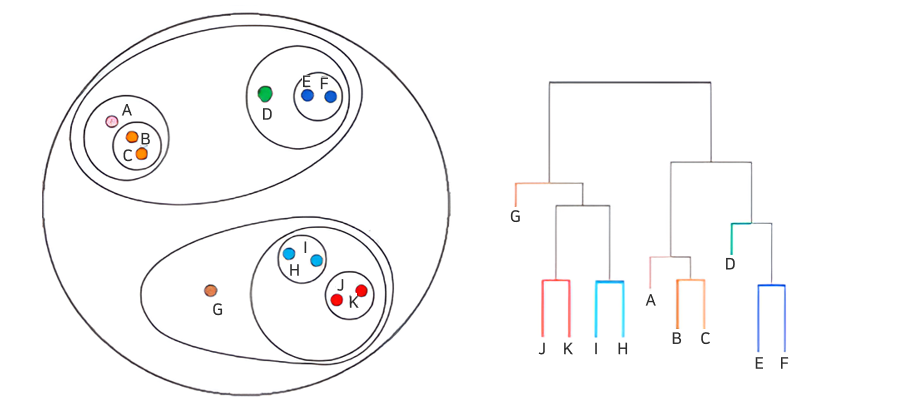

In [ ]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(7)
cluster.fit(train_ft)

AgglomerativeClustering(n_clusters=7)

In [ ]:
silhouette_score(train_ft, cluster.labels_)

0.40333717029910393

In [ ]:
# cluster.predict # 오류

# 실루엣 계수가 높은 k값 선택(비추천)

In [ ]:
for k in range(2,10):
    cluster = KMeans(k, random_state=SEED)
    cluster.fit(train_ft)
    score = silhouette_score(train_ft, cluster.labels_)
    print(k, score)

2 0.29257933985076884
3 0.24379840205983894
4 0.2836894397062517
5 0.30011073716766606
6 0.3492938164123864
7 0.41177112774476704
8 0.4574375986871392
9 0.5050615046570717


# 엘보우(elbow) 방법
- 군집 내 제곱합을 계산하여 K값을 선택하는 방법
- 제곱합(SSE)
    - 데이터 포인트와 해당 군집의 중심점 간의 거리의 제곱합을 의미
- K가 증가할 수록 SSE 값은 급격히 감소하다가 어느 순간부터 감소율이 둔화되는데 이 지점의 K값의 선택하는 방법

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
sse_list = []
for k in range(100, 1001, 50):
    cluster = KMeans(k, random_state=SEED)
    cluster.fit(train_brand)
    sse_list.append(cluster.inertia_)

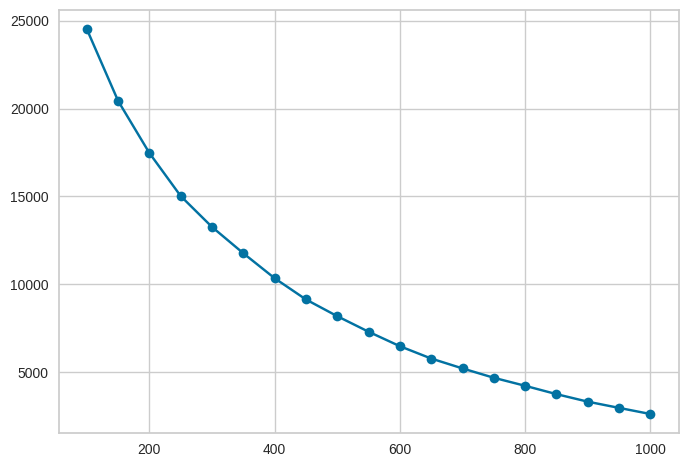

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(100, 1001, 50), sse_list, marker="o")
plt.show()

# yellowbrick
- 머신러닝 관련된 시각화에 특화된 라이브러리
- 사이킷런의 기능과 matplotlib 을 내부적으로 사용
- 설치하기
    ```bash
    pip install yellowbrick
    ```

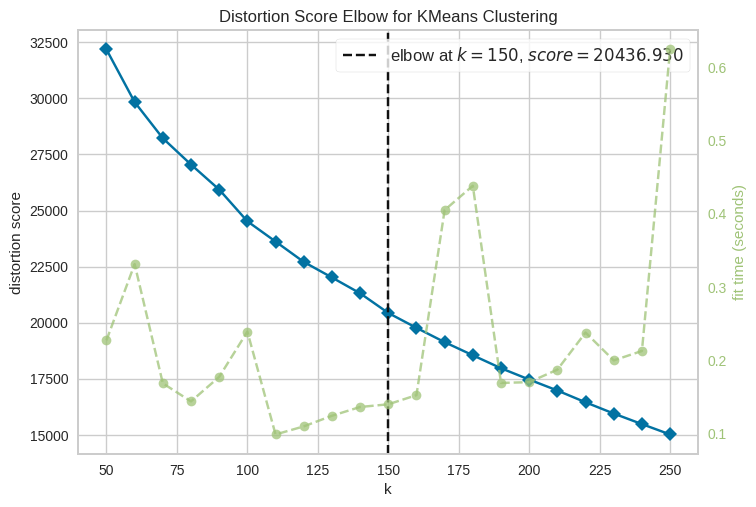

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

num_list = np.arange(50, 251, 10)
# 클러스터 객체, k 파라미터에 k 범위를 전달해주면 됨.
cluster = KMeans(random_state=SEED)
viz = KElbowVisualizer( cluster, k=num_list )
viz.fit(train_brand)
viz.show()
plt.show()

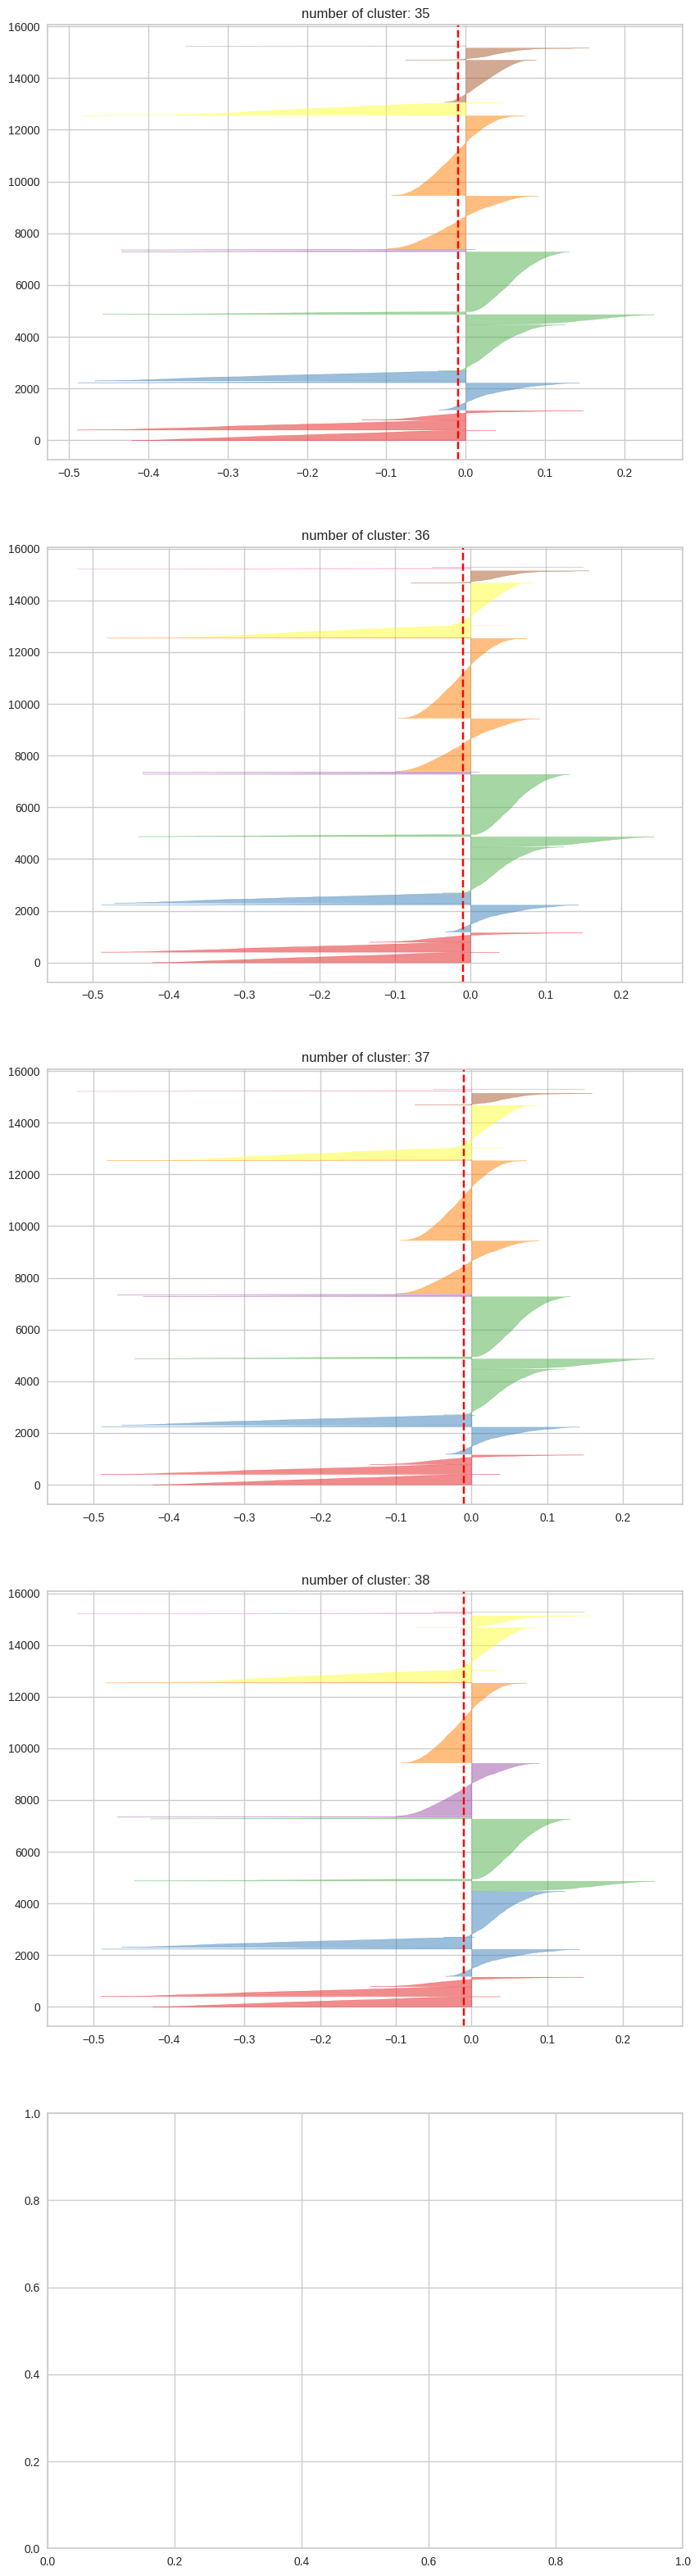

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
fig, ax = plt.subplots(5, figsize=(10,40) )
for i, k in enumerate(range(35,39)):
    cluster = KMeans(k, random_state=SEED)
    ax[i].set_title(f"number of cluster: {k}")
    viz = SilhouetteVisualizer(cluster, ax=ax[i])
    viz.fit(train_ft)
plt.show()

# 군집분석

In [ ]:
cluster = KMeans(13, random_state=SEED)
cluster.fit(train_ft)

KMeans(n_clusters=13, random_state=42)

In [ ]:
train["cluster"] = cluster.labels_
train.head()

,ID,나이,연간소득,주택소유상태,근로기간,대출목적,대출금액,이자율,신용거래기간,target,cluster
0,train_0,26,33996,임대,10.000000,투자,7000,8.00,2,0,1
1,train_1,34,84000,임대,3.000000,개인사업,9000,5.79,10,0,5
2,train_2,22,24702,임대,4.810613,교육,2000,13.23,4,2,3
3,train_3,24,69996,임대,3.000000,부채통합,2500,12.53,3,1,2
4,train_4,26,58125,모기지론,10.000000,투자,6000,10.25,2,1,8


In [ ]:
train["cluster"].value_counts()

,count
cluster,
4,2017
3,1978
2,1733
5,1668
0,1611
1,1601
9,1549
11,1394
6,1356


# 군집별 시각화

In [ ]:
import matplotlib
from matplotlib import font_manager

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv

fontpaths = ["/usr/share/fonts/truetype/nanum/"]
font_files = font_manager.findSystemFonts(fontpaths=fontpaths)

for ff in font_files:
    font_manager.fontManager.addfont(ff)

matplotlib.rc('font', family="NanumGothic")
matplotlib.rcParams['axes.unicode_minus'] = False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,566 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123622 files and dire

In [ ]:
import seaborn as sns

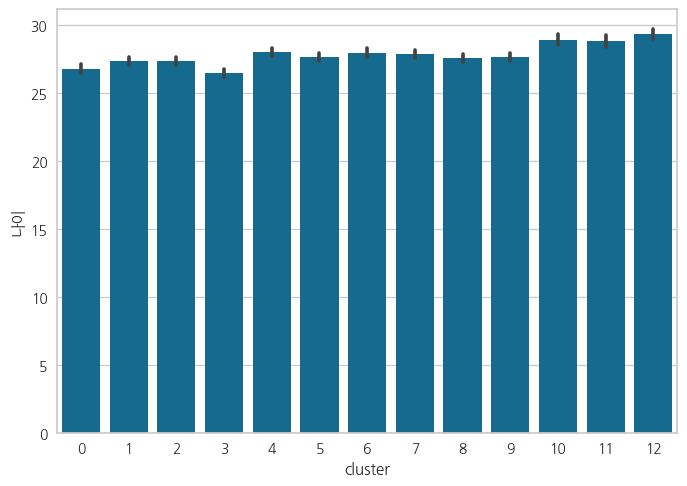

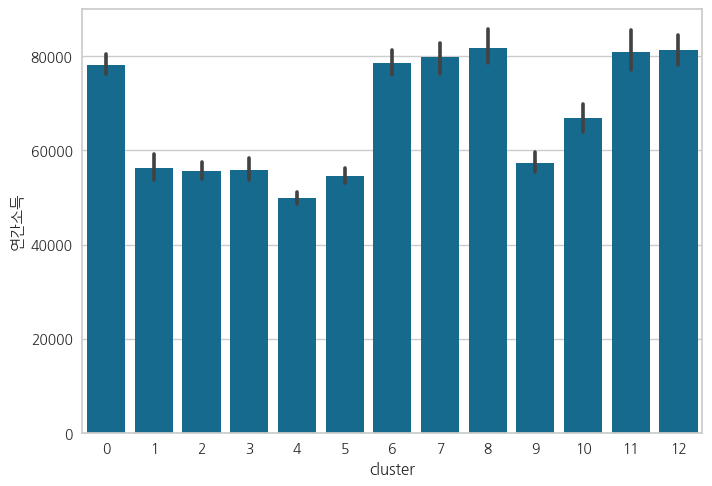

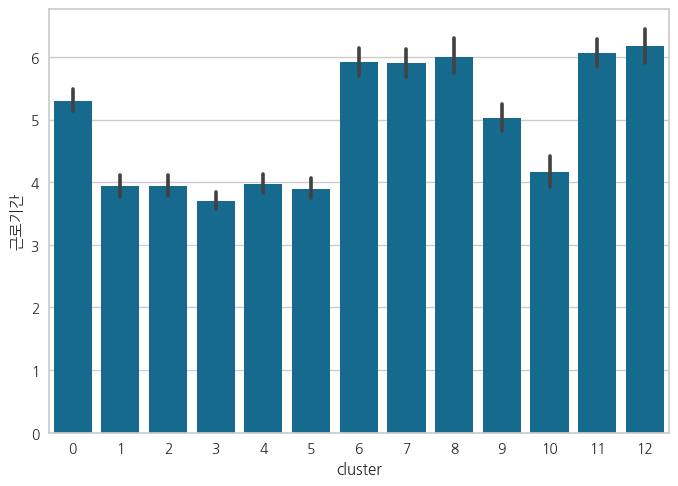

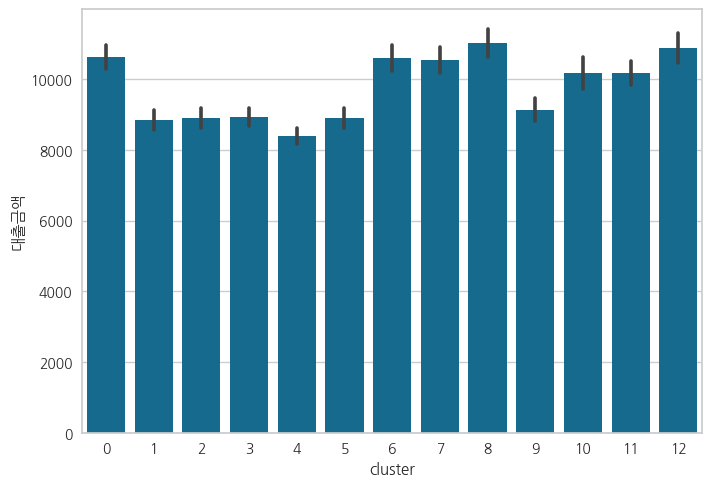

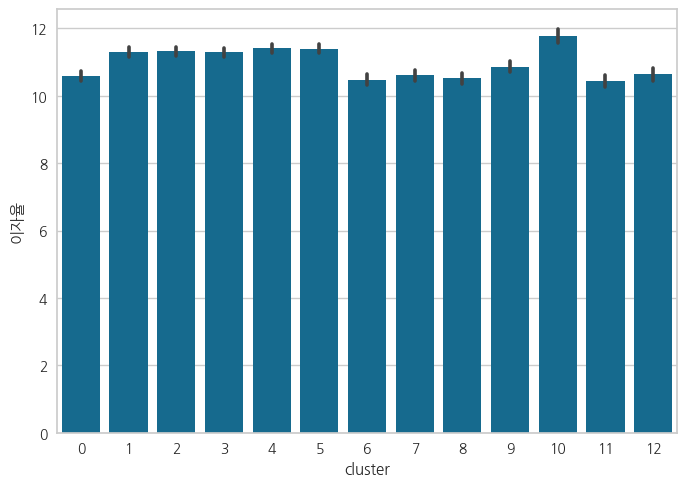

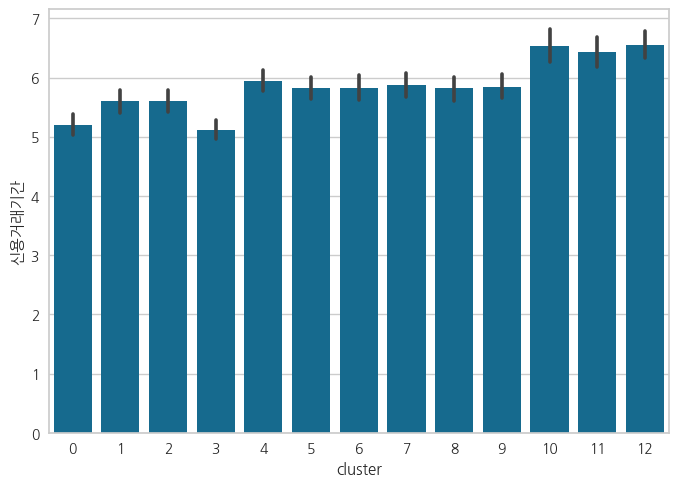

In [ ]:
cols_num = ["나이", "연간소득", "근로기간", "대출금액", "이자율", "신용거래기간"]

for col in cols_num:
    sns.barplot(train, x="cluster", y=col)
    plt.show()
    print()

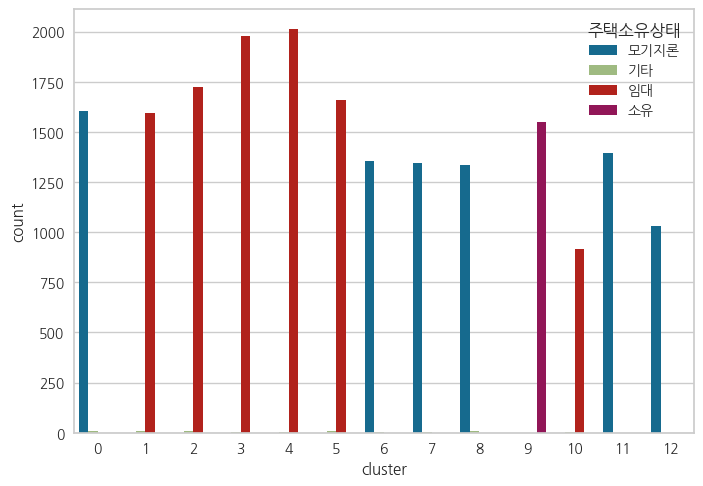

In [ ]:
sns.countplot(train, x="cluster", hue="주택소유상태")
plt.show()

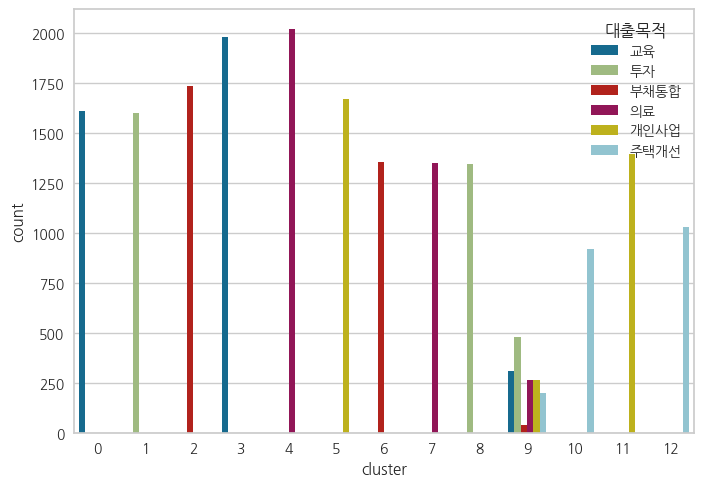

In [ ]:
sns.countplot(train, x="cluster", hue="대출목적")
plt.show()

In [ ]:
df_cluster = []
for i in range(13):
    mask = train["cluster"] == i
    tmp = train.loc[mask].reset_index(drop=True)
    df_cluster.append(tmp)

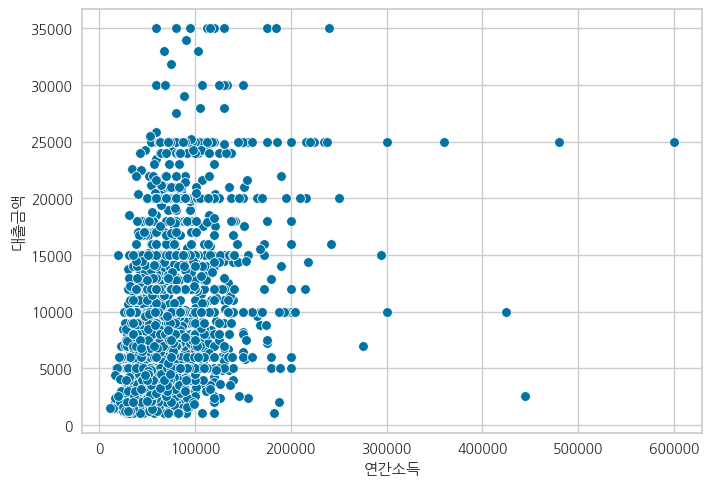

In [ ]:
sns.scatterplot(df_cluster[0], x="연간소득", y="대출금액")
plt.show()

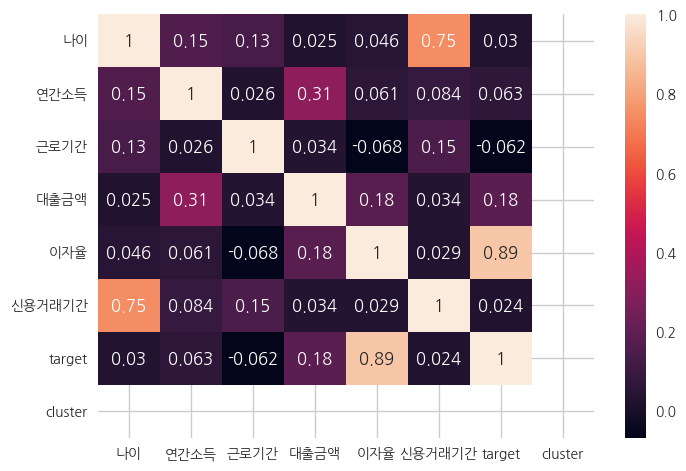

In [ ]:
sns.heatmap(df_cluster[0].corr(numeric_only=True), annot=True)
plt.show()

# 군집분석 응용 해보기

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/data/"

SEED = 42 # 시드값

# 데이터 블러오기
train = pd.read_csv(f"{DATA_PATH}titanic_train.csv") # 학습데이터
test = pd.read_csv(f"{DATA_PATH}titanic_test.csv") # 테스트 데이터

# 결측치 처리
age_mean = train["age"].mean()
fare_median = train["fare"].median()
cabin_unk = "UNK"
embarked_mode = train["embarked"].mode()[0]
train["age"] = train["age"].fillna(age_mean)
train["cabin"] = train["cabin"].fillna(cabin_unk)
test["age"] = test["age"].fillna(age_mean)
test["fare"] = test["fare"].fillna(fare_median)
test["cabin"] = test["cabin"].fillna(cabin_unk)
test["embarked"] = test["embarked"].fillna(embarked_mode)

# 특성으로 사용할 변수 선택
cols = ["age","sibsp","parch","fare","pclass","gender","embarked"]
train_ft = train[cols].copy()
test_ft = test[cols].copy()

# 범주형 변수 원핫인코딩
cols = ['gender','embarked']
enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(train[cols])
tmp = pd.DataFrame(
    enc.transform(train_ft[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
train_ft = pd.concat([train_ft,tmp],axis=1).drop(columns=cols)
tmp = pd.DataFrame(
    enc.transform(test_ft[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
test_ft = pd.concat([test_ft,tmp],axis=1).drop(columns=cols)

# Min-Max Scaling
scaler = MinMaxScaler()
scaler.fit(train_ft)
train_ft[train_ft.columns] = scaler.transform(train_ft)
test_ft[test_ft.columns] = scaler.transform(test_ft)

# 정답 데이터
target = train["survived"]

train_ft.shape, test_ft.shape, target.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


((916, 10), (393, 10), (916,))

In [ ]:
from lightgbm import LGBMClassifier
model = LGBMClassifier(random_state=SEED)
model.fit(train_ft, target)

[LightGBM] [Info] Number of positive: 346, number of negative: 570
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 916, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377729 -> initscore=-0.499198
[LightGBM] [Info] Start training from score -0.499198


LGBMClassifier(random_state=42)

In [ ]:
pred = model.predict(test_ft)
pred

array([0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,

```
K-means 모델을 이용해서 타이타닉 데이터에 대하여 학습을하고
test 데이터에 대하여 0 또는 1로 예측을 수행해주세요.
작성한 코드부분만 저한테 DM으로 주세요
```

In [ ]:
cluster = KMeans(2, random_state=SEED)
cluster.fit(train_ft)

KMeans(n_clusters=2, random_state=42)

In [ ]:
target.mean()

0.3777292576419214

In [ ]:
cluster.labels_.mean()

0.36681222707423583

In [ ]:
pred= cluster.predict(test_ft)
# (pred == 0).astype(int)
pred

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,

In [ ]:
pd.DataFrame(pred, columns=["target"]).to_csv("홍길동.csv")